# Домашнее задание 2 (60 pts)

## Задача 1 (25 pts)
## PLU разложение

- (5 pts) Докажите, что LU разложение существует iff матрица является строго регулярной.
- (15 pts) Поскольку не все матрицы являются строго регулярными, необходимо осуществлять перестановки элементов в ~~строке~~ столбце так, чтобы на диагонали оказался как можно больший по модулю элемент. Это повышает устойчивость процедуры исключения переменных и накопления треугольных факторов. Реализуйте алгоритм вычисления PLU разложения. При этом
    - перестановок ~~столбцов~~ строк достаточно, хотя если вы реализуете алгоритм для PLUQ разложения, то есть будут переставляться и строки и столбцы, то получите бонусные баллы
    - перестановку и обратную к ней необходимо хранить как одномерные массивы. Вам понадобится реализовать функцию для инкрементального обновления перстановки после перехода к следующему диагональному элементу.
    - в качестве опорного элемента достаточно использовать максимальный по модулю элемент в ~~строке~~ столбце
    - не забудьте максимально возможным образом использовать возможности NumPy и исключить циклы там где это возможно  
- (5 pts) Сравните результат работы вашего алгоритма с методом из ```scipy.linalg``` для плохо обусловленной матрицы. Постройте график зависимости работы вашего алгоритма от размерности матрицы, подтверждается ли асимптотика для PLU разложения?  

In [ ]:
# первый пункт

- $(\Leftarrow)$ просто делаем Gauss Elimination: на каждом шаге "наднулевая+1" диагональ образующейся $U$ состоит в точности из спектра главного минора исходной матрицы $A$ и чтобы не делить на ноль на следующем шаге, необходимо чтобы последний элемент этого спектра был ненулевым; также очевидно что L матрица будет нижнетреугольной. $(\Rightarrow)$ если в утверждении допускаются вырожденные матрицы, то это очевдино неправда, контрпример: $L=1,\ U=0$. если же $A$ невырождена и существует разложение $A=LU$, то $0\notin diag(L),\ 0\notin diag(U)$ и очевидно что главный минор $A_k=L_kU_k$ невырожден.

In [ ]:
# второй пункт

# P.S. если A=PLU, то переставляются строки матриц, а не столбцы!

рекурсия с перебросом перестановки через L задается следующим образом:

- $P_1A=L_1U_1,\ L_1=\begin{pmatrix}1&0\\l &\mathbb{I}\end{pmatrix},\ U_1=\begin{pmatrix}*&*\\0 &A'\end{pmatrix}$
- $P'A'=L'U'\Rightarrow P_1A=L_1P_2U_2,\ P_2=\begin{pmatrix}1&0\\0 &P'\end{pmatrix},\ U_2'=\begin{pmatrix}*&*\\0 &L'U'\end{pmatrix},\ L_1P_2=P_2L_2',\ L_2'=\begin{pmatrix}1&0\\P'l &\mathbb{I}\end{pmatrix}\Rightarrow$
- $P_2P_1A=L_2'U_2'=L_2U_2,\ L_2=\begin{pmatrix}1&0\\P'l &L'\end{pmatrix},\ U_2=\begin{pmatrix}*&*\\0 &U'\end{pmatrix}$.

In [69]:
# это как-то неочвеидно, но можно одновременно вычислять L, U в виде (L-Id) + U:
import numpy as np
def LUPDecompose(A):
  P = np.arange(len(A))
  LU = A.copy()

  for i in range(len(A)):
    pi = i+np.argmax(np.abs(LU[i:,i])) # pivot
    if pi != i: 
      P[[i,pi]]  = P[[pi,i]]
      LU[[i,pi]] = LU[[pi,i]]

    LU[i+1:,i] /= LU[i,i]
    LU[i+1:,i+1:] -= LU[i+1:,i:i+1] @ LU[i:i+1,i+1:]
  return LU, P

In [ ]:
# третий пункт

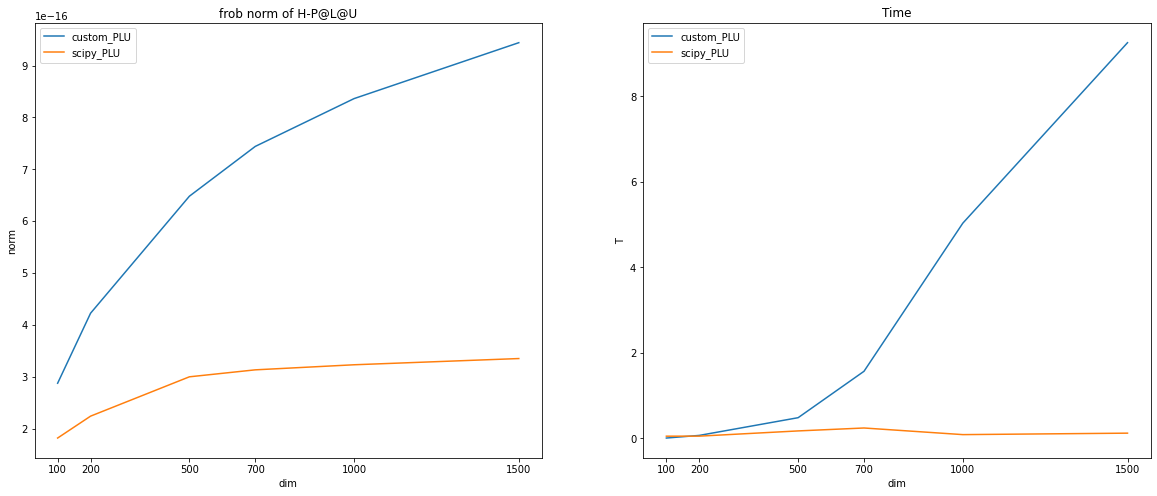

In [70]:
# сравним accuracy по норме фробениуса разности A=H и PLU для scipy и custom
# сравним время исполнения для scipy и custom
from scipy.linalg import lu, hilbert
import matplotlib.pyplot as plt
import time

dims = [100,200,500,700,1000,1500]
T_scipy, T_custom = [], []
Acc_scipy, Acc_custom = [], []
for dim in dims:
  H = hilbert(dim)
  t = time.time()
  p, l, u = lu(H)
  t1 = time.time()
  T_scipy  += [t1-t]
  Acc_scipy += [np.linalg.norm(H-p@l@u, ord='fro')]
  t = time.time()
  LU, p = LUPDecompose(H)
  l, u = np.tril(LU, k=-1) + np.eye(len(LU)), np.triu(LU)
  t1 = time.time()
  T_custom += [t1-t]
  Acc_custom += [np.linalg.norm(H[p]-(l@u), ord='fro')]

fig, ax = plt.subplots(1,2, figsize=(20,8))
ax[0].plot(dims, Acc_custom, label='custom_PLU')
ax[0].plot(dims, Acc_scipy,  label='scipy_PLU')
ax[0].set_xticks(dims)
ax[0].set_xlabel('dim')
ax[0].set_ylabel('norm')
ax[0].set_title('frob norm of H-P@L@U')
ax[0].legend()
ax[1].plot(dims, T_custom, label='custom_PLU')
ax[1].plot(dims, T_scipy,  label='scipy_PLU')
ax[1].set_xticks(dims)
ax[1].set_xlabel('dim')
ax[1].set_ylabel('T')
ax[1].set_title('Time')
ax[1].legend()
plt.show()

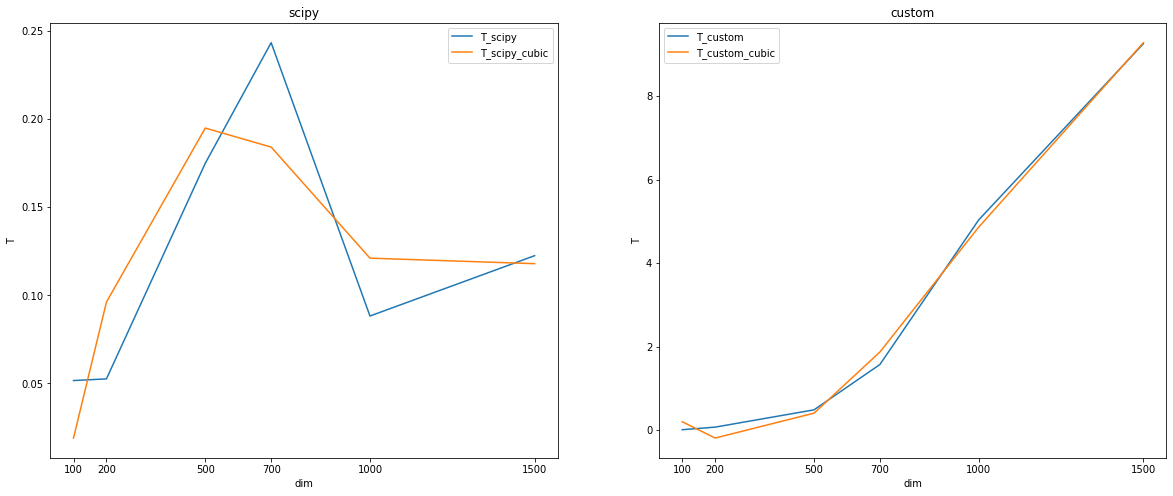

In [71]:
# сложность O(n^3), поглядим насколько хорошо можно аппроксимировать время полиномом

def y3fit(x,y):
  x = np.array(x)
  a,b,c,d = np.polyfit(x, y, 3)
  return a*x**3+b*x**2+c*x+d

fig, ax = plt.subplots(1,2, figsize=(20,8))
ax[0].plot(dims,T_scipy, label='T_scipy')
ax[0].plot(dims,y3fit(dims, T_scipy), label='T_scipy_cubic')
ax[0].set_xticks(dims)
ax[0].set_xlabel('dim')
ax[0].set_ylabel('T')
ax[0].set_title('scipy')
ax[0].legend()
ax[1].plot(dims,T_custom, label='T_custom')
ax[1].plot(dims,y3fit(dims, T_custom), label='T_custom_cubic')
ax[1].set_xticks(dims)
ax[1].set_xlabel('dim')
ax[1].set_ylabel('T')
ax[1].set_title('custom')
ax[1].legend()
plt.show()

## Задача 2 (35 pts)

## Ускорение Андерсена

Многие итерационные методы в вычислительной линейной алгебре могут быть записаны в форме итерации неподвижной точки

$$ x_{k+1} = f(x_k), $$

так что решение задачи удовлетворяет условию $x^* = f(x^*)$. Достаточным условием сходимости такого итерационного процесса для функции $f$ является её Липшецевость с константой $L < 1$ и непрерывная дифференцируемость в окрестности $x^*$  так что $|f'(x^*)| < L$. 
Вокруг итераций такого типа существует довольно много разнообразной теории, но нас будет интересовать специальный способ ускорения сходимости такого итерационного процесса под названием **[ускорение Андерсена](https://en.wikipedia.org/wiki/Anderson_acceleration)**. 
Основная идея метода в представлении следующего приближения как линейной комбинации нескольких предыдущих значений функции $f$, более формально

$$ x_{k+1} = \sum_{i=0}^{m-1} \alpha_i f(x_{k-m+i}), $$

где $m$ - это размер истории, который необходимо хранить и который задаётся до запуска метода, и $\alpha \in \mathbb{R}^m$ ищется как решение следующей задачи оптимизации

$$ \min_{\alpha} \| R\alpha\|_2, \quad \text{subject to} \quad \sum_{i=0}^{m-1} \alpha_i = 1, $$

где $R = [r_{k-m+1}, \ldots, r_{k}]$ и $r_i = f(x_i) - x_i$ вектора невязок.
Отметим, что при $m=1$ мы получим исходную итерацию неподвижной точки.

Заметим, что задача поиска коэффициентов $\alpha_i$ очень похожа на стандартную задачу наименьших квадратов, которую можно решить с помощью функции ```np.linalg.lstsq```, но присутствует дополнительное нормировочное ограничение на коэффициенты. 

- Придумайте, как равносильно преобразовать задачу к виду, который позволит получить решение с помощью функции ```np.linalg.lstsq```.
- Сравните получаемый ответ на случайных данных (матрица $R$) с решением исходной задачи, полученным с помощью функции ```scipy.optimize.minimize```.

### Степенной метод (10 pts)

- Запишите степенной метод в виде итерации неподвижной точки. Чему равна функция $f$?
- Реализуйте ускорение Андерсена для степенного метода с использованием подхода к решению вспомогательной задачи на коэффициенты $\alpha$, полученным выше. Cравните сходимости обычного и ускоренного степенного метода по времени и числу итераций? Рассмотрите различные значения для размера истории и проанализируйте влияние этого гиперпараметра на скорость сходимости (по времени и по числу итераций) 

### Неотрицательное матричное разложение (20 pts)

Задача неотрицательного матричного разложения заключается в поиске разложения данной матрицы на факторы с неотрицательными компонентами, то есть решение следующей задачи оптимизации

$$ \min_{W \geq 0, H \geq 0} \|X - WH\|_F^2, $$

где $X \in \mathbb{R}^{m \times n}$, $W \in \mathbb{R}^{m \times k}$ и $H \in \mathbb{R}^{k \times n}$, так что $k < n$. Известно что такая задача является NP-полной, но существуют различные подходы к её приближённому решению. Одним из таких подходов является идея **попеременной оптимизации**, в которой по очереди фиксируются матрицы $W^{(k)}$ и $H^{(k)}$ и обновляются матрицы $H$ и $W$ соответственно. Так как при фиксированной одной матрице задача становится очень похожа на задачу линейных наименьших квадратов, но с дополнительным ограничением неотрицательности на искомую матрицу.

- Реализуйте наивный алгоритм приближённого решения задачи неотрицательного матричного разложения на основе попеременной оптимизации. Для получения решения всмомогательных задач можно проецировать результат решения линейной задачи наименьших квадратов на множество матриц с неотрицательными элементами. Это делается простым занулением отрицательных элементов, что надеюсь очевидно для вас. Существуют [другие подходы](https://arxiv.org/pdf/1401.5226.pdf) к получению промежуточных значений для матриц $W^{(k)}$ и $H^{(k)}$, которые вы можете протестировать, если выше описанная стратегия не будет сходиться. 


- Одну итерацию обновления матриц $(W, H)$ можно представить как итерацию неподвижной точки вида 

$$(W^{(k+1)}, H^{(k+1)}) = F(W^{(k)}, H^{(k)}), $$

где внутри $F$ спрятаны решения вспомогательных задач оптимизации. А значит реализованный вами выше метод можно ускорить с помощью ускорения Андерсена. Реализуйте ускоренный таким образом метод приближённого решения задачи неотрицательного матричного разложения.

- Рассмотрите задачу тематического моделирования, то есть разбиения документов по темам на основе слов, которые в документах используются. Эту задачу можно формализовать с помощью неотрицательного матричного разложения матрицы "слов-документов", элемент $(i, j)$ которой равен 1 если $i$-ое слово используется в $j$-ом документе. Это самый простой способ представления текстовых документов в виде пригодном для их анализа методами вычислительной линейной алгебры. Можно протестировать чуть более продвинутый способ представления слов и документов под названием tf-idf, подробности [тут](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Для построения матрицы $X$ используйте тестовый датасет [20newsgroup](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups). В контексте этого приложения параметр $k$ - это число тем, матрица $W$ содержит распределение слов по темам, а матрица $H$ коэффициенты разложения каждого документа по темам. Так как все элементы матриц неотрицательны, мы можем интерпретировать их как веса и доли, что упрощает интерпретацию результатов в рамках выбранной предметной области. Сравните на этих данных сходимость базовой и ускоренной реализации метода приближённого решения задачи неотрицательного матричного разложения (по времени и по итерациям). Прокомментируйте полученные результаты. 


### Ускорение Андерсена

- $\argmin\limits_{(\alpha,1)=1}\|R\alpha\|_2=\argmin\limits_{(\alpha,1)=1}\|R\alpha\|^2_2.\quad F(x):=(Rx,Rx)\Rightarrow$

$~$
- $L(\lambda, \alpha)=F(\alpha)+\lambda(1-(\alpha,1))\Rightarrow L'=2R^\top R\alpha-\lambda1=0,\ (\alpha,1)=1\Rightarrow$

$~$
- $\alpha = \frac{\lambda}{2}(R^\top R)^{-1}1,\ \lambda = 2/((R^\top R)^{-1}1,1)\Rightarrow \alpha = \dfrac{(R^\top R)^{-1}1}{((R^\top R)^{-1}1,1)}\Rightarrow$
1) $R^\top Rx=1$
2) $x\rightarrow \dfrac{x}{(x,1)}$

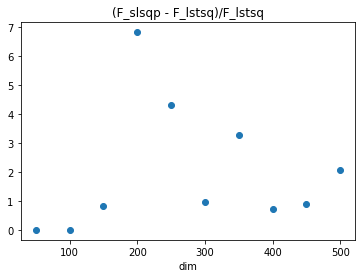

In [240]:
from scipy.optimize import minimize, LinearConstraint
def F(x,R): return np.linalg.norm(R@x)
from tqdm import tqdm

np.random.seed(43)
dims = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
F_lstsq = []
F_slsqp = []
for dim in dims:
  # lstsq
  m = dim
  R = np.random.random((dim, m))
  x, _, _, _ = np.linalg.lstsq(R.T@R, np.ones(m), rcond=None)
  alpha = x / (x@np.ones(m))
  F_lstsq.append(F(alpha,R))

  # SLSQP
  constr = LinearConstraint(np.ones(m), lb=1, ub=1)
  res = minimize(F, np.ones(m), args=(R), method='SLSQP', constraints=(constr))
  alpha1 = res['x']/sum(res['x'])
  F_slsqp.append(F(alpha1,R))

error = (np.array(F_slsqp) - np.array(F_lstsq))/np.array(F_lstsq)
plt.scatter(dims, error)
plt.title('(F_slsqp - F_lstsq)/F_lstsq')
plt.xlabel('dim');

### Степенной метод

$x\rightarrow \dfrac{Ax}{\|Ax\|_2}\Rightarrow f(x)=\dfrac{Ax}{\|Ax\|_2}$


In [578]:
def AA(f, m, x0, tol=1e-5, maxiter=1000, verbose=True):
  dim = len(x0)
  x = x0.copy()
  Fs = np.zeros((m, dim))
  Residuals = np.zeros((m, dim))
  for i in range(maxiter):
    fx = f(x)
    Fs[i%m] = fx
    Residuals[i%m] = fx - x
    if np.linalg.norm(Residuals[i%m])<tol: break

    # currently pointer on i%m and it should be last row so shift it to -1
    # and transpose to obtain shape = (dim, m)
    ResidRolledT = np.roll(Residuals, -i%m-1, axis=0).T

    mk = min(m, i+1) 
    R = ResidRolledT[:,-mk:]
    x, _, _, _ = np.linalg.lstsq(R.T@R, np.ones(mk), rcond=None)
    alpha = x / (x@np.ones(mk))

    FsRolledT = np.roll(Fs, -i%m-1, axis=0).T
    x = FsRolledT[:,-mk:]@alpha
  else:
    if verbose: print('did not converge')
  return i

def simplePower(A, x0, tol=1e-5, maxiter=1000, verbose=True):
  x = x0.copy()
  for i in range(maxiter):
    Ax = A@x
    temp = Ax/np.linalg.norm(Ax)
    if np.linalg.norm(temp-x)<tol: break
    x = temp
  else: 
    if verbose: print('did not converge')
  return i

def powerF(x,A):
  Ax = A@x
  return Ax / np.linalg.norm(Ax)

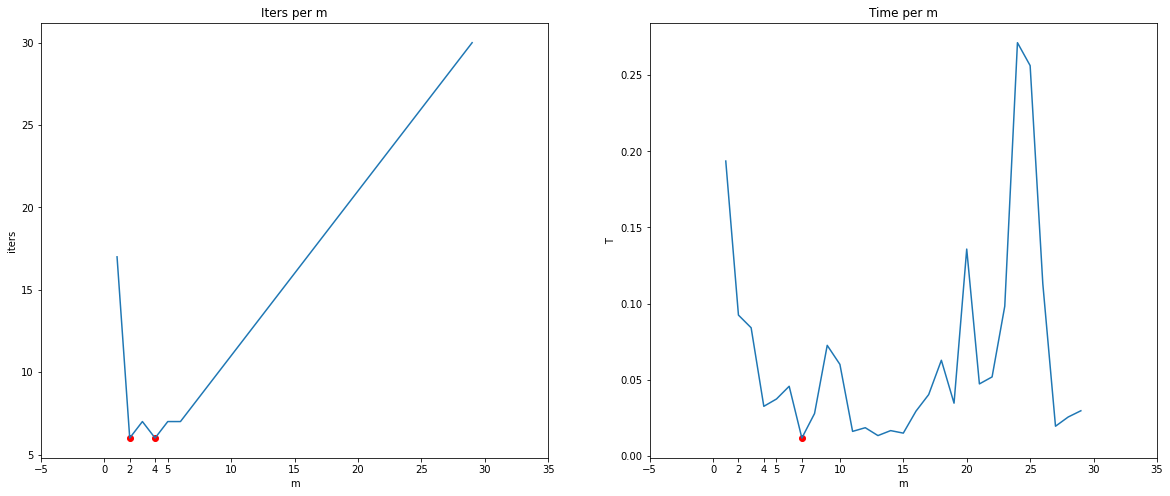

In [388]:
# Сначала найдем "оптимальное" значения m, тестируя на одной и той же матрице Гильберта

np.random.seed(42)
dim = 1000
# A = np.random.random((dim,dim))
# A += A.T
A = hilbert(dim)
x0 = np.random.random(dim)
f = lambda x: powerF(x, A)

TAA = []
ItersAA = []

Ms = np.arange(1,30)
for m in Ms:
  t = time.time()
  itersAA = AA(f = f, m = m, x0 = x0)
  t1 = time.time()
  TAA.append(t1-t)
  ItersAA.append(itersAA)

fig, ax = plt.subplots(1,2, figsize=(20,8))
ax[0].plot(Ms, ItersAA)
ax[0].set_xlabel('m')
ax[0].set_ylabel('iters')
ax[0].set_title('Iters per m')
minI = min(ItersAA)
minMI = [Ms[i] for i in range(len(Ms)) if ItersAA[i]==minI]
ax[0].scatter(minMI, [minI for _ in minMI], color='r')
ax[0].set_xticks(list(ax[0].get_xticks()) + minMI)
ax[1].plot(Ms, TAA)
ax[1].set_xlabel('m')
ax[1].set_ylabel('T')
ax[1].set_title('Time per m') 
minT = min(TAA)
minMT = [Ms[i] for i in range(len(Ms)) if TAA[i]==minT]
ax[1].scatter(minMT, [minT for _ in minMT], color='r')
ax[1].set_xticks(list(ax[1].get_xticks()) + minMI + minMT);

In [386]:
m_optimal = 4
# Сравним обычный и ускоренный
%time iSimple = simplePower(A,x0)
%time iAA = AA(f = f, m = m_optimal, x0 = x0)
print(f'\nIterations:\nsimple: {iSimple}\nAA: {iAA}')

CPU times: user 13.7 ms, sys: 2.66 ms, total: 16.4 ms
Wall time: 234 ms
CPU times: user 6.46 ms, sys: 519 µs, total: 6.98 ms
Wall time: 16.1 ms

Iterations:
simple: 17
AA: 6


In [384]:
# bigger dim but same analysis

np.random.seed(42)
dim = 10000
A = hilbert(dim)
x0 = np.random.random(dim)
f = lambda x: powerF(x, A)

%time iSimple = simplePower(A,x0)
%time iAA = AA(f = f, m = m_optimal, x0 = x0)
print(f'\nIterations:\nsimple: {iSimple}\nAA: {iAA}')

CPU times: user 1.66 s, sys: 595 ms, total: 2.26 s
Wall time: 3.79 s
CPU times: user 737 ms, sys: 22 ms, total: 759 ms
Wall time: 981 ms

Iterations:
simple: 22
AA: 8


если $\lambda_{\max}<0$, то методы расходятся!

In [390]:
np.random.seed(42)
dim = 100
A = -hilbert(dim)
x0 = np.random.random(dim)
f = lambda x: powerF(x, A)

iSimple = simplePower(A,x0)
iAA = AA(f = f, m = m_optimal, x0 = x0)

did not converge
did not converge


посмотрим что будет, если $\lambda_{\max}>0,\ \lambda_{\text{other}}\leq0$. simplePower не будем рассматривать, так как он долго сходится из-за малого $|\lambda_1/\lambda_2|$

In [493]:
from tqdm import tqdm
def testEigAA(maxEigs1, maxEigs2, dim):
  goodPairs = []
  badPairs  = []
  for maxEig1 in tqdm(maxEigs1):
    for maxEig2 in maxEigs2:
      eigenvals = [maxEig1] + list(range(-dim+maxEig2+2,maxEig2+1))
      eigenvecs = np.random.randn(dim, dim)
      A = eigenvecs@np.diag(eigenvals)@np.linalg.pinv(eigenvecs)
      x0 = np.random.random(dim)
      f = lambda x: powerF(x, A)
      iAA = AA(f = f, m = m_optimal, x0 = x0, verbose=False)
      if iAA < dim-1:
        goodPairs.append((maxEig1, maxEig2))
      else:
        badPairs.append((maxEig1, maxEig2))
  return goodPairs, badPairs

dim = 100
maxEigs = [1, 5, 10, 25, 50, 75, 100, 150, 200, 250]
maxEig2 = [-1, -5, -10, -25, -50, -75, -100, -150, -200, -250]

np.random.seed(42)
goodPairs, badPairs = testEigAA(maxEigs, maxEig2, dim)

100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


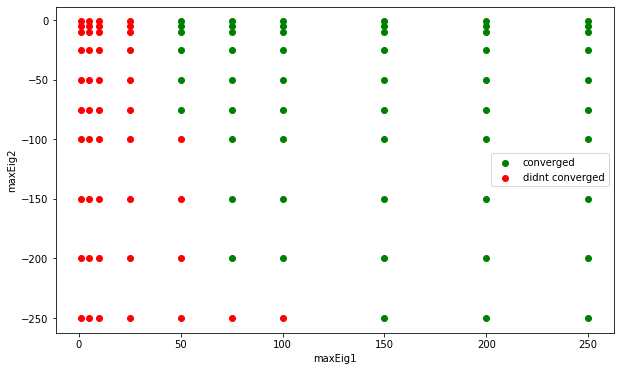

In [494]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(*zip(*goodPairs), color='g', label='converged')
plt.scatter(*zip(*badPairs),  color='r', label='didnt converged')
plt.xlabel('maxEig1')
plt.ylabel('maxEig2')
plt.legend();

прослеживается что-то типа гиперболы, то есть не очень похоже на $|\frac{\lambda_1}{\lambda_2}|>c$


### Неотрицательное матричное разложение

$\|X - WH\|_F^2$
1) $W=W_{\text{fix}}\Rightarrow X\in\mathbb{R}^{mn},\  H\in\mathbb{R}^{kn};\ W\rightarrow W'\in\mathbb{R}^{mn \times kn} = W\otimes\mathbb{I}_n$
2) $H=H_{\text{fix}}\Rightarrow X\in\mathbb{R}^{mn},\  W\in\mathbb{R}^{mk};\ H\rightarrow H'\in\mathbb{R}^{mn \times mk}= \mathbb{I}_m\otimes H^\top$

In [ ]:
# проверим, что то, что я написал - действительно работает:
m, k, n = 5, 6, 7
W = np.random.random((m,k))
H = np.random.random((k,n))

Wflat = W.reshape(-1,1)
Hflat = H.reshape(-1,1)
Wbig = np.kron(W, np.eye(n))
Hbig = np.kron(np.eye(m), H.T)
assert np.allclose((Wbig@Hflat).reshape(m,n), W@H)
assert np.allclose((Hbig@Wflat).reshape(m,n), W@H)

#### РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ (до тематического моделирования):

В чем большие сомнения:
- выбор метрики для лосса: так как хочется сравнивать результаты для различных m,n,k, то я решил использовать $p(x,y)=\|x-y\|_2/\dim(x-y)$, где $\dim = mn.$ это не учитывает k и это может быть плохо.
- выбор распределения для тестов матрицы X. если брать матрицы с элементами имеющими малое std/mean
(например, если генерировать `np.random.random((a,b))+10`), то любые способы расходятся...

Что не сработало:
1) по графикам даже на малых матрицах плохо работало когда я просто сначала фиксировал W потом H (именно в таком порядке) решая задачу lstsq
2) добавление условия $\alpha_i\geq0$ никак не помогло (вместо lstsq я просто использовал minimize SLSQP с `Linearconstraint` и `bonds`)
3) подбор k с помощью SVD: кажется, по выбранной метрике для малых по размеру матриц и для такого распределения которое я для них использую, разница взять k=2 или k такое, при котором кумулятивное `explained_variance_ratio_` больше 0.8 - несущественна. Быть может, данный метод лучше сработает на больших матрицах, но вычисл. мощности и времени не хватит это узнать

Что возможно сработало:
1) вместо того, чтобы всегда забывать H (фиксируя W и решая lstsq на H), я попробовал забывать и в обратную сторону (фиксируя H и решая lstsq на W) после чего усреднил результаты. на некоторых тестах это показало улучшения, но в некоторых ситуациях было хуже (все же тут почти все везде расходится)
2) "рестарты", но не совсем: когда лосс резко делает скачок болле чем на 90% то я обнуляю историю и начинаю обучение с последней точки loss по которой еще не подскочил. в течении всех экспериментов это давало небольшой буст в перформансе (много где если Андерсон сильно расходился, то и с этими рестартами он так же успешно расходился, но в многих случаях рестарты спасли ситуацию)

Что еще надо:
1) никакого универсального решения не представленно, можно зафитить комбинации этих подходов для какого-то выделенного распределения матриц (и я считаю что не существует хороших гиперпараметров на все случаи жизни)
2) я далеко не все способы из статьи попробовал, и еще есть идеи что можно сделать, и хочется это поделать actually

P.S. для небольшой матрицы Гильберта вроде как метод с рестартами работает хорошо (можно вставить `X=hilbert(m)` с одинаковыми m, n и k=2 и посмотреть...)

In [294]:
def AA(f, window, x0, tol=1e-5, maxiter=1000, verbose=True, do_restarts=True, eps=1e-5):
  '''
  почти та же функция что и в степенном методе, но теперь с добавлением рестарта:
  если лосс внезапно подскакивает на 90% отн предыдущего значения, то вся история очищается
  и задается новая точка x0 -- предыдущая при которой лосс не взрывался
  '''
  dim = len(x0)
  x = x0.copy()
  Fs = np.zeros((window, dim))
  Xs = np.zeros((window, dim))
  Xs[0] = x
  Residuals = np.zeros((window, dim))
  losses = []
  restarts = []
  idx = 0
  for i in range(maxiter):
    fx = f(x)
    resid = fx - x
    loss = np.linalg.norm(resid)/np.sqrt(dim)
    if do_restarts and \
        np.any(np.abs(Xs[(idx-1)%window])>tol) and \
        (loss-losses[-1])/losses[-1] > 0.9:
      idx = 0
      x = Xs[(idx-1)%window]
      Residuals = np.zeros((window, dim))
      Fs = np.zeros((window, dim))
      Xs = np.zeros((window, dim))
      Xs[0] = x
      Residuals = np.zeros((window, dim))
      restarts.append(i)

      fx = f(x)
      resid = fx - x
      loss = np.linalg.norm(resid)/np.sqrt(dim)

    losses.append(loss)
    Xs[idx%window] = x
    Fs[idx%window] = fx
    Residuals[idx%window] = resid
    Residuals[idx%window] = fx - x
    if loss<tol or len(losses)>2 and abs(losses[-2]-loss)<tol: break

    ResidRolledT = np.roll(Residuals, -idx%window-1, axis=0).T

    mk = min(window, idx+1) 
    R = ResidRolledT[:,-mk:]
    x, _, _, _ = np.linalg.lstsq(R.T@R, np.ones(mk), rcond=None)
    alpha = x / (x@np.ones(mk))

    FsRolledT = np.roll(Fs, -idx%window-1, axis=0).T
    x = FsRolledT[:,-mk:]@alpha
    x = np.clip(x, eps, None)
    idx += 1
  return x, losses, restarts


def stepHW(flatWH, X, k, eps=1e-5):
  '''
  сначала сделаем lstsq в порядке [Wfix, Hfix], 
  потом в обратно порядке [Hfix, Wfix] и результаты усредним
  '''
  m, n = X.shape
  Xflat = X.reshape(-1,1)
  # Wfix-Hfix
  W = flatWH[:m*k].reshape(m,k)
  Wbig = np.kron(W, np.eye(n))
  Hflat, _, _, _ = np.linalg.lstsq(Wbig, Xflat, rcond=None)
  Hflat = np.clip(Hflat, eps, None)
  H = Hflat.reshape(k,n)
  Hbig = np.kron(np.eye(m), H.T)
  Wflat, _, _, _ = np.linalg.lstsq(Hbig, Xflat, rcond=None)
  Wflat = np.clip(Wflat, eps, None)
  res1 = np.vstack((Wflat, Hflat)).reshape(-1)
  
  # Hfix-Wfix
  H = flatWH[m*k:].reshape(k,n)
  Hbig = np.kron(np.eye(m), H.T)
  Wflat, _, _, _ = np.linalg.lstsq(Hbig, Xflat, rcond=None)
  Wflat = np.clip(Wflat, eps, None)
  W = Wflat.reshape(m,k)
  Wbig = np.kron(W, np.eye(n))
  Hflat, _, _, _ = np.linalg.lstsq(Wbig, Xflat, rcond=None)
  Hflat = np.clip(Hflat, eps, None)
  res2 = np.vstack((Wflat, Hflat)).reshape(-1)
  return (res1+res2)/2

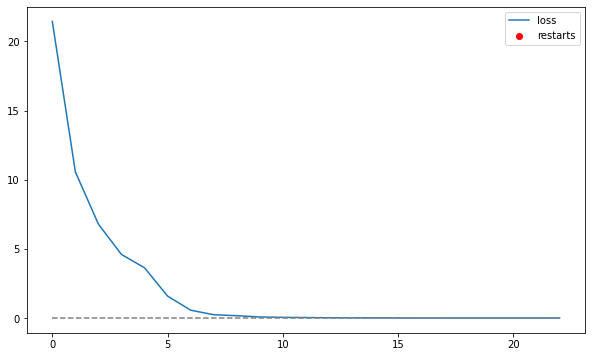

In [295]:
np.random.seed(42)
m, n = 20, 25
X  = np.random.random((m,n))*100

# # SVD k-choice:
# from sklearn.decomposition import TruncatedSVD
# explained_treshold = 0.8
# fitSVD = TruncatedSVD(n_components=min(X.shape), random_state=42).fit(X)
# k = np.where(fitSVD.explained_variance_ratio_.cumsum()>explained_treshold)[0][0]
# k = max(min(m,n)//2+1, k)

k = 2

x0 = np.random.random(m*k+k*n).reshape(-1)
f  = lambda x: stepHW(x, X, k)
flatWH, losses, restarts = AA(f=f,window=4,x0=x0,do_restarts=True)

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(losses, label='loss')
plt.plot(np.arange(len(losses)), losses[-1:]*len(losses), linestyle='dashed', color='grey')
plt.yticks(list(i for i in plt.xticks()[0] if i!=0) + [losses[-1]])
plt.scatter(restarts, np.array(losses)[restarts], color='r', label='restarts')
plt.legend();

In [288]:
# так можно получить W, H:
W, H = flatWH[:m*k].reshape(m,k), flatWH[m*k:].reshape(k,n)

### Задача тематического моделирования

предложенный ранее способ не сработает ввиду
 
`Unable to allocate 1.06 PiB for an array with shape (226280, 656948161) and data type float64`

и нужно все итерации обернуть в `scipy.sparce`

- базовый итерационный метод еще можно подождать пока доработает (1 итерацю.. и то я так и не дождался), но никакой тюнинг невозможен из-за громадных размеров кронекеровских матриц, а об методе Андерсена еще страшнее думать, так как мне не удалось красивым образом сделать np.roll аналог у `scipy.sparce` и времени должно уйти в ~ 2 раза больше на итерацию.
- есть предположение, что я очень неэффективно перевел задачу для lstsq, и я не нашел такого метода или их аналогов для матриц
- уже под конец работы я задумался, что можно же просто выкинуть часть выборки, так как просто невозможно обрабатывать такой массив данных (~1млрд столбцов...)

...

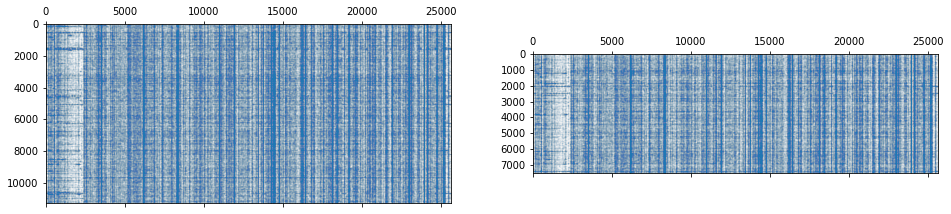

In [4]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

def load_dataset():
  """Load and vectorize the 20 newsgroups dataset."""
  data_train = fetch_20newsgroups(
    subset="train",
    shuffle=True,
    random_state=42,
    remove=(),
  )
  data_test = fetch_20newsgroups(
    subset="test",
    shuffle=True,
    random_state=42,
    remove=(),
  )
  target_names = data_train.target_names
  y_train, y_test = data_train.target, data_test.target
  vectorizer = TfidfVectorizer(
    sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
  )
  X_train = vectorizer.fit_transform(data_train.data)
  X_test  = vectorizer.transform(data_test.data)
  feature_names = vectorizer.get_feature_names_out()
  return X_train, X_test, y_train, y_test, feature_names, target_names

X_train, X_test, y_train, y_test, feature_names, target_names = load_dataset()

fig,ax = plt.subplots(1,2, figsize=(16,12))
ax[0].spy(X_train, markersize=0.005)
ax[1].spy(X_test,  markersize=0.005);

In [31]:
from scipy.sparse.linalg import lsqr
from scipy import sparse
from tqdm import tqdm

def fixedPointStep(X,W,H):
  m, k = W.get_shape()
  k, n = H.get_shape()
  Wbig = sparse.kron(W, sparse.eye(n))
  Hflat = lsqr(Wbig, X.reshape(1,-1).toarray())[0]
  Hflat[Hflat < 0] = 0
  Hflat = sparse.csr_matrix(Hflat)
  H = Hflat.reshape(k,n)
  Hbig = sparse.kron(sparse.eye(m), H.T)
  Wflat = lsqr(Hbig, X.reshape(1,-1).toarray())[0]
  Wflat[Wflat < 0] = 0
  Wflat = sparse.csr_matrix(Wflat)
  return Wflat.reshape(m,k),  Hflat.reshape(k, n)

def baseMethod(X, W0, H0, tol = 1e-5, maxiter = 3):
  W, H = W0.copy(), H0.copy()

  for i in tqdm(range(maxiter)):
    Wnew, Hnew = fixedPointStep(X,W,H)
    if sparse.linalg.norm(Wnew-W, ord='fro') <tol and sparse.linalg.norm(Hnew-H, ord='fro'):
      break
    W, H = Wnew, Hnew
  return W, H

In [32]:
# # too heavy, dont use!
# k = len(target_names)
# m, n = X_train.get_shape()
# W0 = sparse.random(m, k)
# H0 = sparse.random(k, n)
# W, H = baseMethod(X_train, W0, H0)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [11:44<?, ?it/s]


KeyboardInterrupt: 